In [1]:
import numpy as np
from numpy import random

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import math

In [5]:
from scipy.stats import bernoulli

# Functions

In [6]:
def remaining_jobs(remaining_service_times):
    return np.array([i for i in range(N) if remaining_service_times[i] >= 1])

def holding_cost(mean_values, jobs):
    return np.sum([mean_values[i] for i in jobs])

In [7]:
def select_job(t, samples, jobs):
    empirical_means = np.array([np.mean(samples[i][0:t+1]) for i in jobs])
    return jobs[np.argmax(empirical_means)]

def select_job_pre(t, samples, service_times, jobs):
    c_mu = np.array([(np.mean(samples[i][0:t+1]) / service_times[i]) for i in jobs])
    return jobs[np.argmax(c_mu)]

def serve(i, remaining_service_times):
    remaining_service_times[i] -= 1
    
def complete(i, remaining_service_times):
    remaining_service_times[i] = 0

In [8]:
def optimal(mean_values):
    sorted_values = np.sort(mean_values)
    total_cost = 0
    for i in range(N):
        total_cost += (N-i)*T*sorted_values[i]
    return total_cost

In [9]:
def preemptive(mean_values, samples):
    remaining_service_times = np.array([T for i in range(N)])
    total_holding_cost = 0
    for t in range(N*T):
        active_jobs = remaining_jobs(remaining_service_times)
        total_holding_cost += holding_cost(mean_values, active_jobs)
        serve(select_job(t, samples, active_jobs), remaining_service_times)
        #serve(select_job_pre(t, samples, remaining_service_times, active_jobs), remaining_service_times)
    return total_holding_cost

In [10]:
def nonpreemptive(mean_values, samples):
    remaining_service_times = np.array([T for i in range(N)])
    total_holding_cost = 0
    for i in range(N):
        active_jobs = remaining_jobs(remaining_service_times)
        total_holding_cost += T*holding_cost(mean_values, active_jobs)
        complete(select_job(i*T, samples, active_jobs), remaining_service_times)
    return total_holding_cost

In [11]:
def preemptive_then_nonpreemptive(mean_values, samples):
    S = math.floor( (T**(2/3)) * (np.log(N*T)) / C)
    remaining_service_times = np.array([T for i in range(N)])
    total_holding_cost = 0
    for t in range(S):
        active_jobs = remaining_jobs(remaining_service_times)
        total_holding_cost += holding_cost(mean_values, active_jobs)
        serve(select_job(t, samples, active_jobs), remaining_service_times)
    
    time_steps_past = S
    for i in range(N):
        active_jobs = remaining_jobs(remaining_service_times)
        job_chosen = select_job(time_steps_past, samples, active_jobs)
        remaining_service_time = remaining_service_times[job_chosen]
        total_holding_cost += remaining_service_time*holding_cost(mean_values, active_jobs)
        time_steps_past += remaining_service_time
        complete(job_chosen, remaining_service_times)
    return total_holding_cost

# Running experiments

- $N$ is the number of jobs
- $T$ is the service time of each job, counted as the number of required time steps
- $T_s$ is set to $T^{2/3}\log NT$ in our paper, but it is okay to have 
$$T_s = C\left(T^{2/3}\log NT\right)$$
for any constant multiplicative factor.

In [12]:
N = 20
T = 2000
C = 10

# the length of the alternation period
math.floor( (T**(2/3)) * (np.log(N*T)) / C) 

168

## Creating an output file

In [14]:
def create_output_files():
    column_labels = ['num_jobs', 'service_time', 'eps', 'instance_number', 'OPT', 
                     'preemptive', 'non-preemptive', 'pre-non-pre']
    df = pd.DataFrame(columns=column_labels)
    df.to_csv('results_raw_data.csv', index=False)

In [15]:
create_output_files()

## Sampling mean holding costs

- preemtive scheduling is appropriate when $c_1,\ldots, c_N$ have large gaps.
- non-preemptive scheduling is better when $c_1,\ldots, c_N$ are close.
- We sample $c_1,\ldots,c_N$ from $[0.5-\epsilon, 0.5+\epsilon]$ while varying the size of $\epsilon$.
- When $\epsilon$ is small, non-preemtive scheduling is expected to be better than preemptive scheduling.
- When $\epsilon$ is large, preemptive scheduling should be better.

In [13]:
eps_list = np.array([0.01*i for i in range(51)])
eps_list[0] = 0.001

## Testing different values of $\epsilon$

## Drawing plots

### Regret

The regret value of an algorithm is defined as follows:
$$\text{Regret = the total holding cost of the algorithm - the minimum holding cost (OPT)}.$$

We compare three different algorithms:
- preemptive: serve jobs in a fully preemptive fashion.
- nonpreemptive: serve jobs in a fully nonpreemptive fashion.
- preemptive-then-nonpreemptive: our algorithm

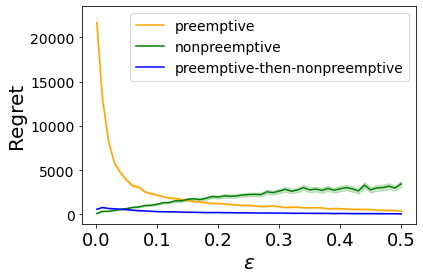

In [6]:
df = pd.read_csv('results/uniform/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 2000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive'], label='nonpreemptive', color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre'], label='preemptive-then-nonpreemptive', color = 'blue')

plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
plt.savefig('uniform-regret.pdf', bbox_inches = 'tight')

### Relative regret

The notion of approximation ratio is a measure of analyzing an algorithm, which is defined as 
$$\frac{\text{Total holding cost of the algorithm}}{\text{Minimum holding cost (OPT)}}.$$

Here, we look at a related quantity, which we call the "relative regret", defined as
$$\frac{\text{Regret}}{\text{Minimum holding cost (OPT)}}\text{ = the approximation ratio }-1$$

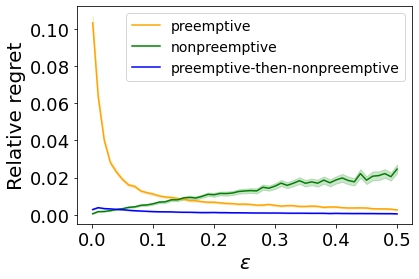

In [7]:
df = pd.read_csv('results/uniform/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['service_time'] == 2000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive']/filtered['OPT'], label='preemptive', color = 'orange')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive']/filtered['OPT'], label='nonpreemptive',  color = 'green')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre']/filtered['OPT'], label='preemptive-then-nonpreemptive', color='blue')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Relative regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('uniform-relative.pdf', bbox_inches = 'tight')

### Dependence on $T$ ($N=20$ & $\epsilon=0.001$)

#### Up to $T=100000$

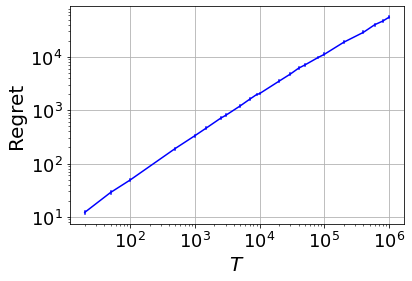

In [8]:
df = pd.read_csv('results/dependence/results_raw_data.csv')
filt = (df['num_jobs'] == 20) & (df['preemptive'] == 0) & (df['service_time'] <1200000)
filtered = df[filt]
sns.lineplot(x=filtered['service_time'], y=filtered['pre-non-pre'], err_style="bars", color='blue')
plt.xlabel(r'$T$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.savefig('uniform-T.pdf', bbox_inches = 'tight')

### Dependence on $N$ ($T=1000$ fixed & $\epsilon=0.001$)

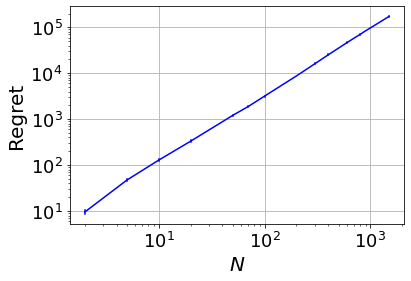

In [9]:
df = pd.read_csv('results/dependence/results_raw_data.csv')
filt = (df['service_time'] == 1000) & (df['preemptive'] == 0)
filtered = df[filt]
sns.lineplot(x=filtered['num_jobs'], y=filtered['pre-non-pre'], err_style="bars", color='blue')
plt.xlabel(r'$N$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.savefig('uniform-N.pdf', bbox_inches = 'tight')